In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib as mpl
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import ternary


p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## 220830 adding arrows to simplex

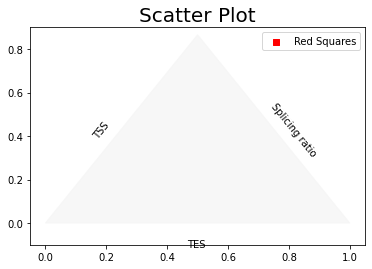

In [2]:
fig, tax = ternary.figure()
tax.set_title("Scatter Plot", fontsize=20)
points = [(1,1), (2,1)]
tax.scatter(points, marker='s', color='red', label="Red Squares")
tax.legend()
tax.left_axis_label('TSS')
tax.right_axis_label('Splicing ratio')
tax.bottom_axis_label('TES')

In [3]:
tax._labels['left']

('TSS', (-0.08, 0.6, 0.4), 60, {})

In [4]:
tax._labels

{'left': ('TSS', (-0.08, 0.6, 0.4), 60, {}),
 'right': ('Splicing ratio', (0.48000000000000004, 0.6, 0), -60, {}),
 'bottom': ('TES', (0.5, -0.01, 0.5), 0, {})}

In [5]:
def left_axis_arrow(tax, position=None,  rotation=60, offset=0.08,
                    **kwargs):
    """
    Sets the label on the left axis.

    Parameters
    ----------
    label: String
        The axis label
    position: 3-Tuple of floats, None
        The position of the text label
    rotation: float, 60
        The angle of rotation of the label
    offset: float,
        Used to compute the distance of the label from the axis
    kwargs:
        Any kwargs to pass through to matplotlib.
    """

    if not position:
        position = (-offset, 3./5, 2./5)
    tax._arrows["left"] = ('', position, rotation, kwargs)

def right_axis_arrow(tax, position=None, rotation=-60, offset=0.08,
                     **kwargs):

    """
    Sets the label on the right axis.

    Parameters
    ----------
    label: String
        The axis label
    position: 3-Tuple of floats, None
        The position of the text label
    rotation: float, -60
        The angle of rotation of the label
    offset: float,
        Used to compute the distance of the label from the axis
    kwargs:
        Any kwargs to pass through to matplotlib.
    """

    if not position:
        position = (2. / 5 + offset, 3. / 5, 0)
    tax._arrows["right"] = ('', position, rotation, kwargs)

def bottom_axis_arrow(tax, position=None, rotation=0, offset=0.02,
                      **kwargs):
    """
    Sets the label on the bottom axis.

    Parameters
    ----------
    label: String
        The axis label
    position: 3-Tuple of floats, None
        The position of the text label
    rotation: float, 0
        The angle of rotation of the label
    offset: float,
        Used to compute the distance of the label from the axis
    kwargs:
        Any kwargs to pass through to matplotlib.
    """

    if not position:
        position = (0.5, -offset / 2., 0.5)
    tax._arrows["bottom"] = ('', position, rotation, kwargs)

In [8]:
SQRT3 = np.sqrt(3)
SQRT3OVER2 = SQRT3 / 2.

def project_point(p, permutation=None):
    """
    Maps (x,y,z) coordinates to planar simplex.

    Parameters
    ----------
    p: 3-tuple
        The point to be projected p = (x, y, z)
    permutation: string, None, equivalent to "012"
        The order of the coordinates, counterclockwise from the origin
    """
    permuted = permute_point(p, permutation=permutation)
    a = permuted[0]
    b = permuted[1]
    x = a + b/2.
    y = SQRT3OVER2 * b
    return np.array([x, y])

def permute_point(p, permutation=None):
    """
    Permutes the point according to the permutation keyword argument. The
    default permutation is "012" which does not change the order of the
    coordinate. To rotate counterclockwise, use "120" and to rotate clockwise
    use "201"."""
    if not permutation:
        return p
    return [p[int(permutation[i])] for i in range(len(p))]


In [39]:
abs(-60)

60

In [78]:
def draw_arrows(tax):
    """Redraw axis labels, typically after draw or resize events."""
    # Redraw the labels with the appropriate angles
    ax = tax.get_axes()
    arrow_data = list(tax._arrows.values())
    for (label, position, rotation, kwargs) in arrow_data:
        transform = ax.transAxes
        print(rotation)
        x = position[0]
        y = position[1]
        dx = (1/3)*math.sin(abs(rotation))
        dy = (1/3)*math.sin(90-abs(rotation))
        x2 = x+dx
        y2 = y+dy
        z2 = sum(position)-(x2+y2)
        # print(position)
        # print((x2,y2,z2))
        # print()
        print('x, x2')
        print((x, x2))
        print('y, y2')
        print((y, y2))
        proj_x, proj_y = project_point(position)
        
        position = np.array([proj_x, proj_y])
        new_rotation = ax.transData.transform_angles(
                np.array((rotation,)), position.reshape((1, 2)))[0]
        
        proj_x2, proj_y2 = project_point((x2, y2, z2))
        proj_dx = proj_x2-proj_x
        proj_dy = proj_y2-proj_y
        print('x proj, x2 proj')
        print((proj_x, proj_x2))
        print('y proj, y2_proj')
        print((proj_y, proj_y2))
        print('new rotation')
        print(new_rotation)
        print()
        

        arrow = ax.arrow(proj_x, proj_y,
                         proj_dx, proj_dy, head_width=0.02,
                         width=.0005,
                          **kwargs)


60
x, x2
(-0.08, -0.18160354036740556)
y, y2
(0.6, 0.27065612530237937)
x proj, x2 proj
(0.21999999999999997, -0.046275477716215874)
y proj, y2_proj
(0.5196152422706631, 0.2343950802017247)
new rotation
51.05654304257676



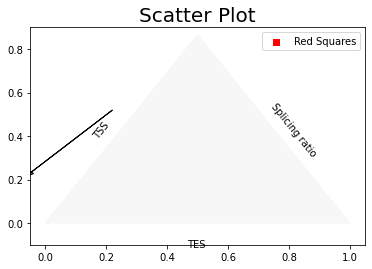

In [80]:
fig, tax = ternary.figure()
tax.set_title("Scatter Plot", fontsize=20)
points = [(1,2), (2,1)]
tax.scatter(points, marker='s', color='red', label="Red Squares")
tax.legend()
tax.left_axis_label('TSS')
tax.right_axis_label('Splicing ratio')
tax.bottom_axis_label('TES')
tax._arrows = {}
left_axis_arrow(tax)
# right_axis_arrow(tax)
# bottom_axis_arrow(tax)
draw_arrows(tax)

## 220816 genes where sr == tss == tes

In [12]:
ca = cerberus.read('cerberus_annot_triplets.h5')

In [13]:
df = ca.triplets

In [15]:
df = df.loc[df.source == 'obs_det']

In [18]:
print(len(df.index))
df = df.loc[(df.n_tss == df.splicing_ratio)&(df.n_tss == df.n_tes)]
print(len(df.index))

26781
8796


In [20]:
print(len(df.index))
df = df.loc[df.n_tss > 1]
print(len(df.index))


8796
163


In [21]:
df.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
14,obs_det,ENSG00000001617,2.0,2.0,4.0,7.0,2.0,SEMA3F,NaN,NaN
515,obs_det,ENSG00000035720,2.0,2.0,4.0,7.0,2.0,STAP1,NaN,NaN
559,obs_det,ENSG00000040487,3.0,3.0,9.0,11.0,3.0,SLC66A1,NaN,NaN
577,obs_det,ENSG00000042429,4.0,4.0,16.0,23.0,4.0,MED17,NaN,NaN
644,obs_det,ENSG00000049245,2.0,2.0,4.0,5.0,2.0,VAMP3,NaN,NaN


In [23]:
df.sort_values(by='n_tss', ascending=False).head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
13976,obs_det,ENSG00000182220,5.0,5.0,25.0,31.0,5.0,ATP6AP2,NaN,NaN
7137,obs_det,ENSG00000137312,5.0,5.0,25.0,42.0,5.0,FLOT1,NaN,NaN
10461,obs_det,ENSG00000163479,4.0,4.0,16.0,19.0,4.0,SSR2,NaN,NaN
577,obs_det,ENSG00000042429,4.0,4.0,16.0,23.0,4.0,MED17,NaN,NaN
11498,obs_det,ENSG00000167645,4.0,4.0,16.0,20.0,4.0,YIF1B,NaN,NaN


In [22]:
df.to_csv('obs_det_triplets_111.tsv', sep='\t', index=False)

## What novelty is that one mef2c transcript

In [3]:
ca = cerberus.read('cerberus_annot.h5')

In [5]:
ca.tss.head()

,Chromosome,Start,End,Strand,Name,source,novelty,gene_id,tss
0,chr1,169794989,169795129,+,ENSG00000000460_1,"v40,v29,lapa,gtex,encode_cage,fantom_cage,enco...",Known,ENSG00000000460,1
1,chr1,169795358,169795459,+,ENSG00000000460_2,"v40,v29,lapa,pls",Known,ENSG00000000460,2
2,chr1,169794679,169794780,+,ENSG00000000460_3,"v40,v29,lapa,gtex,pls",Known,ENSG00000000460,3
3,chr1,169795870,169795971,+,ENSG00000000460_4,"v40,v29,pls",Known,ENSG00000000460,4
4,chr1,169661956,169662057,+,ENSG00000000460_5,"v40,v29,dels",Known,ENSG00000000460,5


In [7]:
ca.tss.loc[(ca.tss.gene_id=='ENSG00000081189')&(ca.tss.tss==1)].novelty

44405    Known
Name: novelty, dtype: object

In [8]:
ca.tes.loc[(ca.tes.gene_id=='ENSG00000081189')&(ca.tes.tes==20)].novelty

70064    Known
Name: novelty, dtype: object

In [10]:
ca.ic.loc[(ca.ic.gene_id=='ENSG00000081189')&(ca.ic.ic==43)]

,Chromosome,Strand,Coordinates,Name,source,novelty,gene_id,ic
192589,chr5,-,88882954-88823927-88823734-88804801,ENSG00000081189_43,"v40,v29,lapa",Known,ENSG00000081189,43


## PolyA gene detection at 0, 1, and 100 TPM

In [3]:
ab = '../talon/human_talon_abundance.tsv'
ver = 'v40_cerberus'

In [18]:
df = pd.read_csv(ab, sep='\t')
df, inds = get_tpm_table(df,
                   how='gene',
                   gene_subset='polya',
                   min_tpm=0)

gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', ver=ver)

polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.index)

print('Detected {} / {} ({:.3}%) annotated polyA genes'.format(n_det_polya, n_polya, (n_det_polya/n_polya)*100))

tpm_df = df.copy(deep=True)
tpm_dfs = []
tpm_dfs.append(tpm_df)
tpm_dfs.append(tpm_df.loc[(tpm_df >= 1).any(axis=1)])
tpm_dfs.append(tpm_df.loc[(tpm_df >= 100).any(axis=1)])

det_df = pd.DataFrame()
for df, tpm in zip(tpm_dfs, [0,1,100]):
    gene_df, _, _ = get_gtf_info(how='gene', subset='polya', ver=ver, add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'gname', 'biotype_category']]

    df.reset_index(inplace=True)
    df = df.merge(gene_df, how='left', on='gid_stable')

    df = df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
    df.rename({'gid_stable':'obs_counts'}, axis=1, inplace=True)

    gene_df = gene_df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
    gene_df.rename({'gid_stable':'annot_counts'}, axis=1, inplace=True)
    df = df.merge(gene_df, how='left', left_index=True, right_index=True)

    df['perc'] = (df.obs_counts/df.annot_counts)*100
    df = df.sort_values(by='perc', ascending=False)
    df['tpm_thresh'] = tpm
    det_df = pd.concat([det_df, df])
    
det_df = det_df.reset_index()
det_df.head()

In [87]:
det_df

,biotype_category,obs_counts,annot_counts,perc,tpm_thresh
0,protein_coding,19246,19988,96.287773,0
1,lncRNA,12715,17748,71.641875,0
2,pseudogene,7720,14538,53.102215,0
3,protein_coding,18727,19988,93.691215,1
4,lncRNA,10713,17748,60.361731,1
5,pseudogene,4332,14538,29.797771,1
6,protein_coding,9776,19988,48.909346,100
7,lncRNA,254,17748,1.431147,100
8,pseudogene,101,14538,0.694731,100


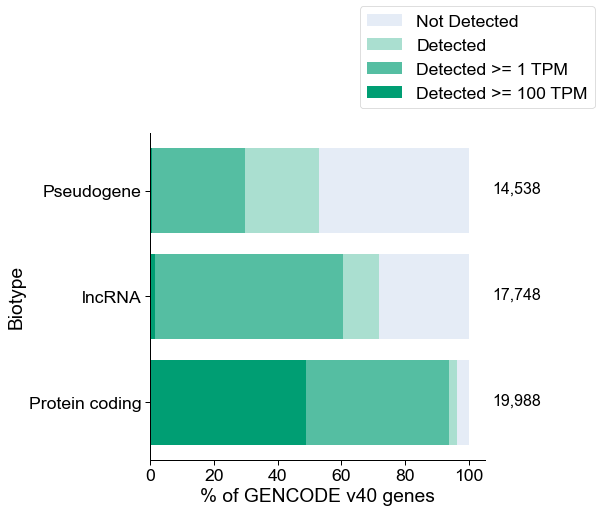

In [86]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(6,6))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
ic_colors, order = get_ic_nov_colors()
gray = get_sector_colors()[0]['simple']
c = ic_colors['Known']
cats = [100,1,0]
c_dict, order = get_shade_colors(c, cats)
order.reverse()
biotypes = ['protein_coding', 'lncRNA', 'pseudogene']
b_dict = {'protein_coding': 'Protein coding',
          'lncRNA': 'lncRNA',
          'pseudogene': 'Pseudogene'}

# https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
def add_n(rects, label):
    ax = plt.gca()
    for rect in rects:
        # height = rect.get_height()
        x = rect.get_y()+rect.get_height()/2.3
        y = rect.get_width()*1.15
        ax.text(y,x,
                '{:,}'.format(label),
                ha='center', va='bottom', size=16)

for b in biotypes:
    x = b_dict[b]
    y = 0
    rects = plt.barh(x, [100], color=gray)
    # add total number of genes
    n = det_df.loc[(det_df.biotype_category == b)&(det_df.tpm_thresh==0), 'annot_counts'].tolist()[0]
    add_n(rects, n)
    
    for c in order:
        curr_y = det_df.loc[(det_df.biotype_category == b)&(det_df.tpm_thresh==c), 'perc'].tolist()[0]
        plt.barh(x, [curr_y], color=c_dict[c])
        y = y+curr_y
    


leg_labels = ['Not Detected', 'Detected', 'Detected >= 1 TPM', 'Detected >= 100 TPM']
plt.legend(leg_labels, bbox_to_anchor=(.6, 1.05))
ax = plt.gca()
leg = ax.get_legend()

# plt.yticks(rotation=90)

plt.ylabel('Biotype')
plt.xlabel('% of GENCODE v40 genes')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fname = 'figures/gene_det_by_biotype.png'
plt.savefig(fname, dpi=500, bbox_inches='tight')
fname = 'figures/gene_det_by_biotype.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')